# How many rounds should a BP tournament have?

_Chuan-Zheng Lee <czlee@stanford.edu>_

There was discussion at the institutional representatives meeting at the 2016 United States Universities Debating Championships (USUDC) about how many rounds it should have. That discussion is behind us now, but in case a similar one should arise in the _future_, I decided to use some simulation code from a previous discussion about power-pairing to look at the question.

I would like for the focus of this notebook **not** to be the decision that was made, nor any individual who made arguments in the meeting, not least because I wasn't there. It's been steadily dawning on me that, as a community, we don't understand our tournament structures as well as we think we do. Examining this necessarily requires implicit critiques of particular arguments, but my objective is more to present some tools for thinking about tournament structures.

There are, too, plenty of arguments not relating to the "accuracy of the break" that one could make. In reality, hard logistical constraints take precedence over everything. There is also direct value in getting more practice and feedback. This notebook addresses none of these. Furthermore, there was (I hear) some discussion about the effect of position balance. This concern, too, is orthogonal to the considerations of this notebook. Among other things, it relies on the premise that some positions are systematically advantageous, which is a question about the debate format, not draw tabulation.

People in theoretical disciplines tend to be a bit hesitant about relying on simulations like this, at least those without some more proper analytical grounding. For this and a myriad of other reasons that essentially collapse into “this topic is all a massive open question”, I don't provide any firm general positive conclusions.

The core code that runs the simulation is in powerpairing.jl, which is in this directory (or [on GitHub here](https://github.com/czlee/debate-pairing/blob/master/powerpairing.jl)).

In [1]:
using PyPlot
using Interact
include("powerpairing.jl")
ntournaments = 300;

In [2]:
function simulateandplot(nteams, nrounds)
    positions = simulatemanytournaments(pairpower4, ntournaments, nteams, nrounds) # in powerpairing.jl
    boxplot(positions)
    plot([0, nteams], [0, nteams], color=(1, 1, 0))
    xlabel("true rank")
    ylabel("actual rank")
    xticks(yticks()[1], map(Int, yticks()[1]))
    title("Rank distributions after $nrounds rounds")
end;

## The motivating case study

The most direct simulation to have a look at is obviously one reflecting the tournament at hand. USUDC 2016 had 180 teams, so let's have a look at that first.

To generate each plot, we simulate 300 tournaments and observe the actual (simulated) rank of each team. Each box (column) is a team, best team on the left, worst on the right. The box shows the distribution of actual ranks from the simulated tournaments. Some important assumptions and notes:

* We model teams' "true" abilities as being ranked from first to last, and a "better" team _always_ beats a "worse" team (not just most of the time).
* All pairings and pull-ups are random, as per WUDC rules.
* When generating the final _actual_ rank from a tournament, however, teams are assumed to ranked "correctly" within brackets. So teams are ranked first by bracket, then by "true ability". You can think of it as modelling an assumption that within brackets, speaker scores will be a proxy for "true ability".

Now, what does it mean to be "fair"? This is a deep philosophical question. But if one part of it is to get an _accurate_ break, it seems reasonable to want the _true_ top 32 teams (or however many break) to be the ones in the _actual_ top 32 teams. But remember that in all tournaments, there is an element of randomness—not just from team and adjudicator performance, which is not accounted for in this model, but from the _draw itself_. More specifically, under WUDC rules (and the rules that most BP tab software use), pairings are random in the first round, and pairings within brackets and pull-ups are random in all subsequent rounds. I submit that a pertinent goal of fairness is to minimize the effect of this randomness on the accuracy of the break.

On this metric, we'd want the box and whiskers to be (a) as _short_ as possible (_i.e._ as little variance) and (b) to track as closely to the $x = y$ line as possible. Ideally, we'd want to define how we measure "closely". But that's quite nontrivial to do, so let's just have a look at the graphs directly.

For visual convenience, I've drawn the $x = y$ line in yellow on top of the box and whiskers.

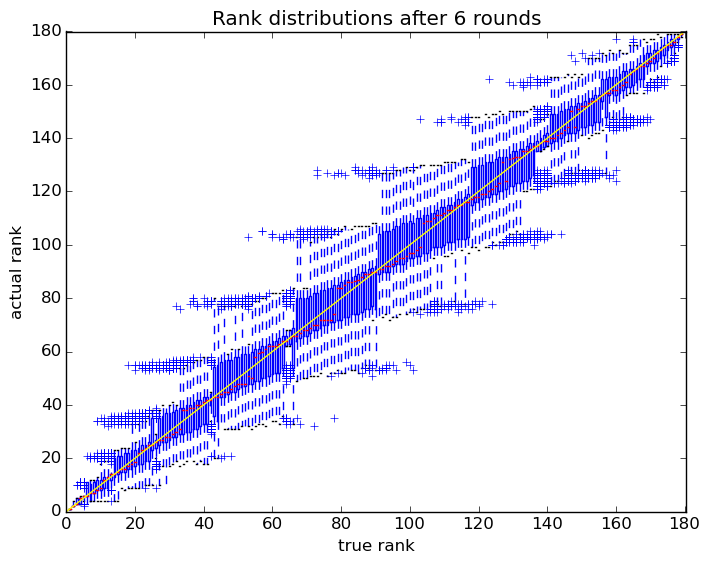

In [3]:
simulateandplot(180, 6);

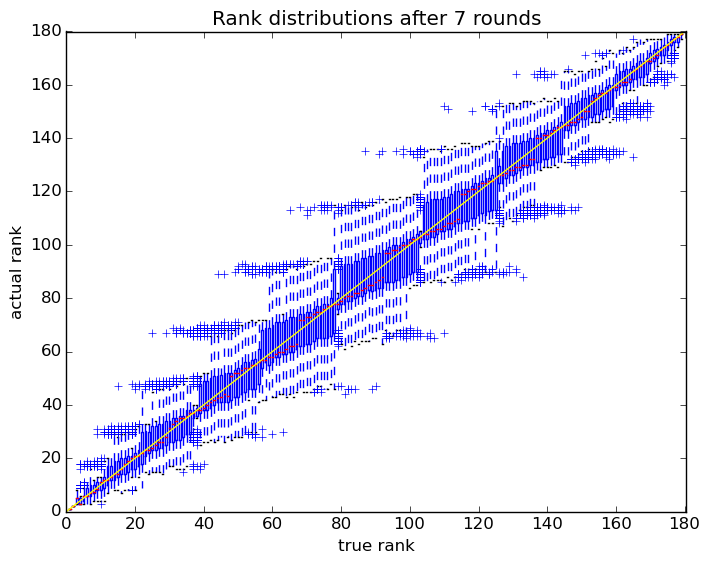

In [4]:
simulateandplot(180, 7);

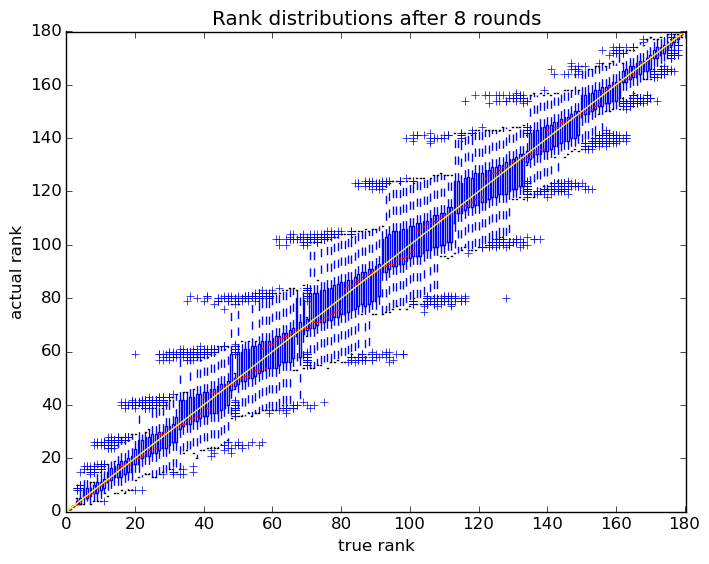

In [5]:
simulateandplot(180, 8);

Those plots are a little dense, and if we mainly care about breaking we should probably focus on the teams that either do break or should break. Let's zoom in a little. We'll need to look at teams outside the top 32 who might make it in as well, so we'll zoom in to the top 60 teams.

The green lines are where the 32nd team is. Teams left of the vertical line _should_ break. Teams below the horizontal line _do_ break.

I leave you to judge how these plots compare to each other. If you don't think the three plots look that different, it's worth bearing in mind that this does _not_ mean the seventh and eighth rounds are pointless. There are some things the model I used doesn't account for, for example, variance in team and adjudicator performance.

In [6]:
function zoomtooctofinals()
    xlim(0, 60)
    ylim(0, 60)
    plot(xlim(), [32.5, 32.5], color=(0, 1, 0))
    plot([32.5, 32.5], ylim(), color=(0, 1, 0))
    xticks(yticks()[1], map(Int, yticks()[1]))
end;

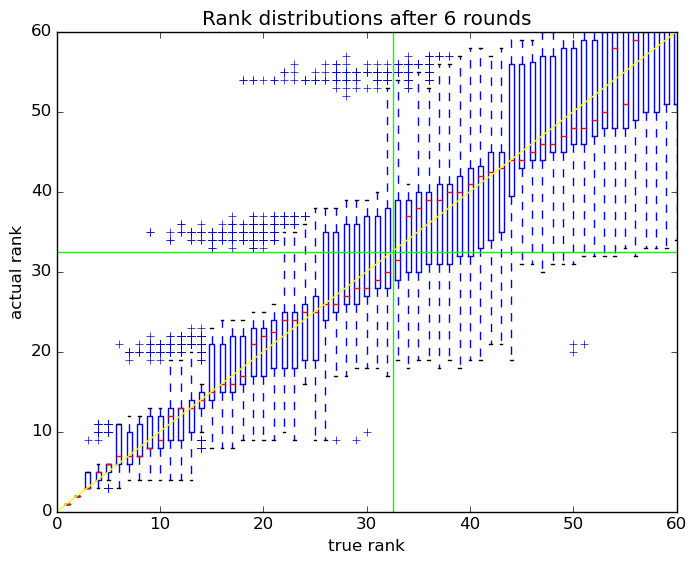

In [7]:
simulateandplot(180, 6)
zoomtooctofinals();

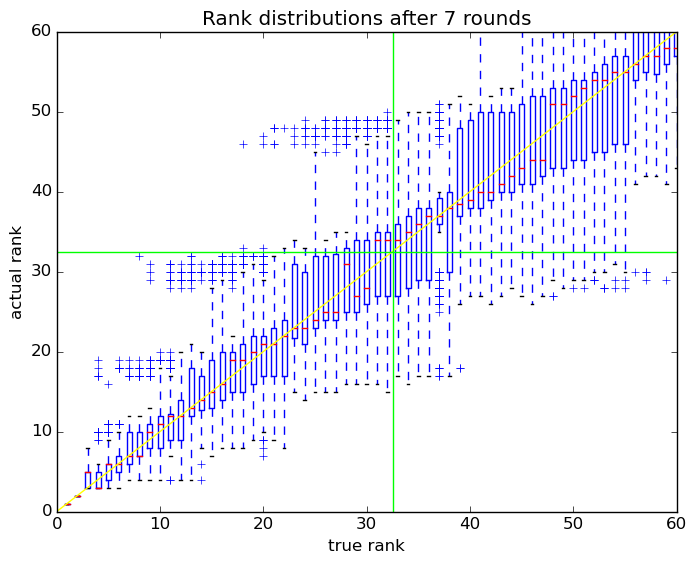

In [8]:
simulateandplot(180, 7)
zoomtooctofinals();

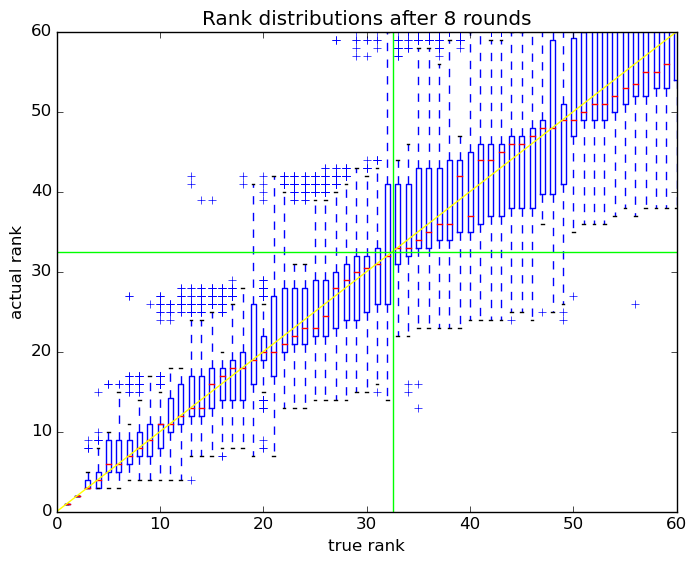

In [9]:
simulateandplot(180, 8)
zoomtooctofinals();

## Using smaller cases to try to gain intuition

We might attempt to derive intuition from smaller cases. This is a common practice in mathematics, though of course one must always be careful not to assume that observations from small numbers generalize well to large numbers (they often don't).

**This section is interactive**, so **you need to be running this in Jupyter Notebook with a Julia kernel (not just a viewer)**. To get a slider to appear, in the menu above, click **Cell**, then **Run All**. It can take a few minutes, so be patient. You need to wait for all the asterisks in "`In [*]:`" on the left to change to numbers. (If there are no menus, that means you're in a viewer.) Then drag the slider to adjust the number of rounds (`nrounds`).

The 16-team case is the smallest nice-round-number (a power of 4) nontrivial case, so let's start there. You'll notice that it seems to be quite good after two rounds, but it gets worse after three rounds.

What happened? We're seeing the effect of an underlying issue with BP power-pairing. If, at any point, your teams are perfectly sorted, then after the next round, some will leap-frog others because some teams will gain three points, while teams in the room immediately below will gain zero points. This introduces variance into the sorting.

We might also be surprised that the sorting is relatively good after _two_ rounds rather than one. This turns on an assumption about the first-round pairings. If the first-round pairings are completely seeded (in the same way as a quarter-final) then you're actually guaranteed to be perfectly sorted after the _first_ round, and your sorting will get messy in the second round. But if the first-round pairings are random, the second round helps reduce the effects of randomness of the first round.

For example, there's a possibility that the 3rd team will randomly hit the 1st or 2nd teams in the first round, and thus rank 5th or 9th after round 1. If they don't get a first in round 1, then they're guaranteed to win round 2 (since 2nd and 3rd can't _both_ take a second in round 1), catapulting them back up to 5 points and a happy 3rd or 4th place.

Interact.Slider{Int64}(Signal{Int64}(4, nactions=0),"nrounds",4,1:8,true)

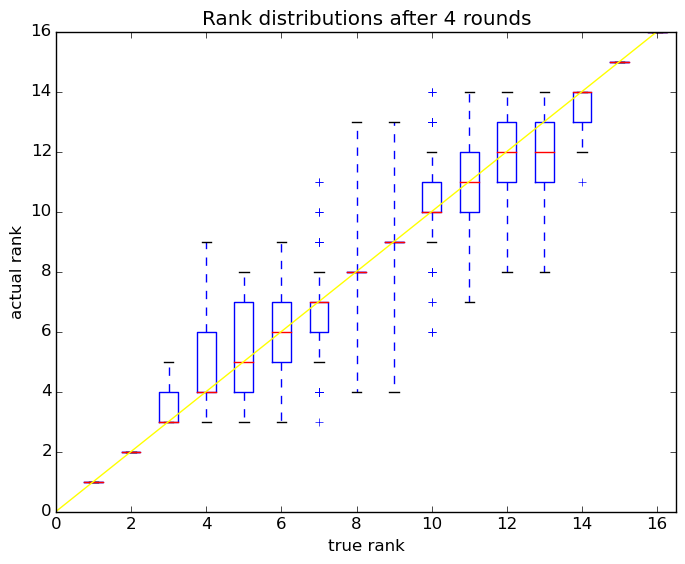

In [10]:
f2 = figure()
@manipulate for nrounds in 1:8
    withfig(f2) do
        simulateandplot(16, nrounds)
    end
end

We might be tempted to draw broader conclusions from this case, but it relies on a very important coincidence: that things look okay after two rounds. For any tournament of appreciable size, this is very hard (maybe practically impossible) to do. Even at 64 teams (the next power of 4), we see that it's basically the more rounds the better. There's nothing intrinsic, for example, about having an odd or even number of rounds that should affect the accuracy of the break, at least not under this model.

Interact.Slider{Int64}(Signal{Int64}(4, nactions=0),"nrounds",4,1:8,true)

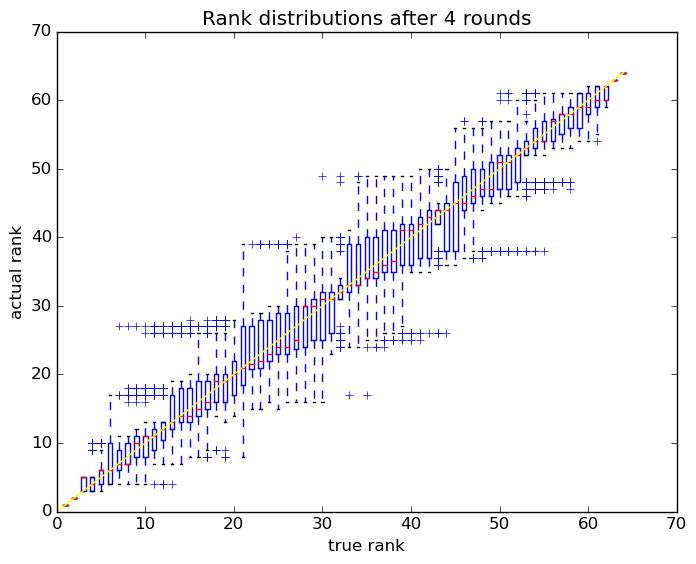

In [11]:
f2 = figure()
@manipulate for nrounds in 1:8
    withfig(f2) do
        simulateandplot(64, nrounds)
    end
end